# 0. Load libraries/dataset

In [1]:
# Load libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cluster import DBSCAN, KMeans
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree

from os.path import isfile

sns.set(style='ticks', color_codes=True)

# Load dataset
data_path = './datasets/assignment08_dataset.csv'

species = pd.DataFrame()
if not isfile(data_path):
    print("Dataset not found. Please check that the dataset exists and the path is correct.")
    
else:
    species = pd.read_csv(data_path)
    
# Make sure we have a copy of the orginal dataset
species_org = species.copy()

display(species)

,f1,f2
0,0.494261,1.451067
1,-1.428081,-0.837064
2,0.338559,1.038759
3,0.119001,-1.053976
4,1.122425,1.774937
...,...,...
745,0.505927,1.213927
746,-1.640461,-0.469973
747,-0.057139,-0.909261
748,-1.169394,0.039597


# 1. How many species are in this dataset?

Using a scatterplot we see that there are three 'blobs,' so it is likely that there are three species in the dataset.

Text(0, 1.0, '$f_2$')

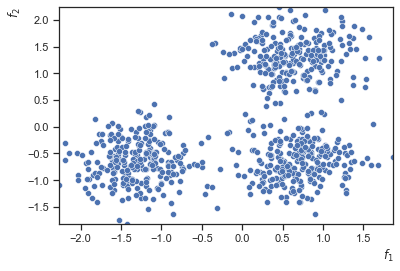

In [2]:
f1_max = species['f1'].max()
f1_min = species['f1'].min()

f2_max = species['f2'].max()
f2_min = species['f2'].min()

sns.scatterplot(x=species['f1'], y=species['f2'])
    
plt.xlim(f1_min, f1_max)
plt.ylim(f2_min, f2_max)
plt.xlabel(r'$f_1$', horizontalalignment='right', x=1.0)
plt.ylabel(r'$f_2$', horizontalalignment='right', y=1.0)

# 2. Find the rough feature ranges to classify these species correctly.

Based on the plots below let:
* species_a be the f1, f2 range \[-2.0:-0.7, -1.5:0.0\]
* species_b be the f1, f2 range \[0.0:1.3, -1.3:0.0\]
* species_c be the f1, f2 range \[0.0:1.4, 0.5:2.0\]

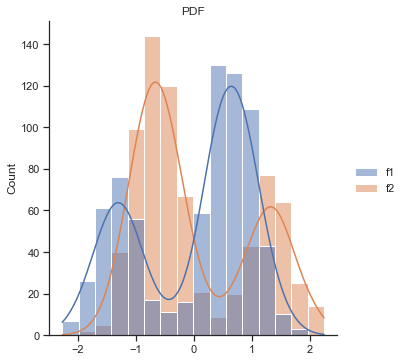

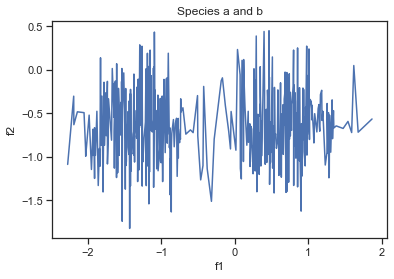

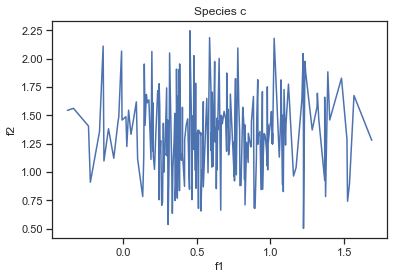

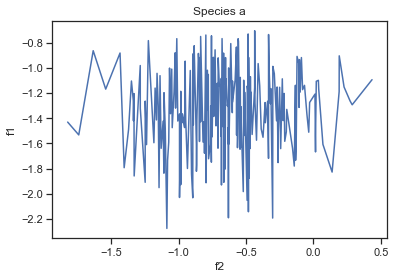

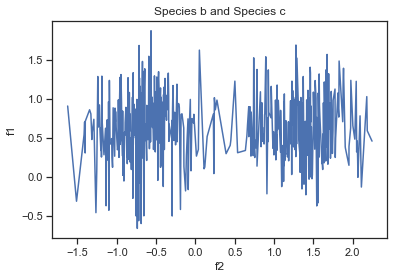

<Figure size 432x288 with 0 Axes>

In [3]:
# Let's see the beginning probability distribution
sns.displot(species, kde=True)
plt.title("PDF")
plt.show()
plt.clf()

# Let's subdivide and lineplot so we can eyeball 'em  a little closer
# f1's
specia_a_b = species[species['f2'] < 0.5]
sns.lineplot(x=specia_a_b['f1'], y=specia_a_b['f2'])
plt.title("Species a and b")
plt.show()
plt.clf()

specia_c = species[species['f2'] > 0.5]
sns.lineplot(x=specia_c['f1'], y=specia_c['f2'])
plt.title("Species c")
plt.show()
plt.clf()

# f2's
specia_a = species[species['f1'] < -0.7]
sns.lineplot(x=specia_a['f2'], y=specia_a['f1'])
plt.title("Species a")
plt.show()
plt.clf()

specia_b_c = species[species['f1'] > -0.7]
sns.lineplot(x=specia_b_c['f2'], y=specia_b_c['f1'])
plt.title("Species b and Species c")
plt.show()
plt.clf()


# 3. Clean the data of outliers.

Species a has 216) samples.
Species b has 212) samples.
Species c has 215) samples.


<AxesSubplot:xlabel='f1', ylabel='f2'>

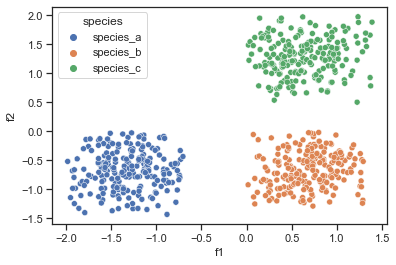

In [4]:
# Define the bounds as we defined in (2.)
species_a_bounds = {'f1': (-2.0,-0.7), 'f2':(-1.5,0.0)}
species_b_bounds = {'f1': (0.0,1.3), 'f2':(-1.3,0.0)}
species_c_bounds = {'f1': (0.0,1.4), 'f2':(0.5,2.0)}
          
# Function for isolating each species
def bound_species(bounds):
    temp_species = species.copy()
    
    for feat in bounds:
        lower = bounds[feat][0]
        upper = bounds[feat][1]
        
        temp_species = temp_species[temp_species[feat] > lower]
        temp_species = temp_species[temp_species[feat] < upper]
        
    return temp_species

# Isolate the species
species_a = bound_species(species_a_bounds)
species_b = bound_species(species_b_bounds)
species_c = bound_species(species_c_bounds)

# Add 'species' column to each (for hueing)
species_a['species'] = ['species_a']*species_a.shape[0]
species_b['species'] = ['species_b']*species_b.shape[0]
species_c['species'] = ['species_c']*species_c.shape[0]

# Display the number of samples from each, 
# so we know we haven't bounded one too aggressively.
disp_string = lambda df, name: print(f"{name} has {df.shape[0]}) samples.")
disp_string(species_a, "Species a")
disp_string(species_b, "Species b")
disp_string(species_c, "Species c")

# Concat into single bounded species table
bd_species = [species_a, species_b, species_c]
bd_species = pd.concat(bd_species)

# Show results
show_scatter = lambda df: sns.scatterplot(x=df['f1'], y=df['f2'], hue=df['species'])
show_scatter(bd_species)

# 4. Use K-means clustering to find anomalies.

Here we define a few functions including detect_anomaly(), which will find all points that are greater than 1 standard-deviation from the centroid of either assignment function (here km_assigner for K-Means; later dbs_assigner for DBScan).

In [5]:
# Function to detect anomalies with KM clustering
def detect_anomaly(df, assigner, verbose=True):
    # Drop our species assignments
    try:
        df = df.drop(columns=['species'])
    except KeyError:
        pass
    
    # Get assignments and centroids
    assigns, centroids = assigner(df)
    
    # Add assignments as 'species'
    df['species'] = assigns

    # Find the anomalies
    anomalies = []
    
    # For each species,
    for spec in df['species'].unique():
        # make temp copy of df
        anom_df = df.copy()
        
        # get cluster groups
        anom_df = anom_df[anom_df['species'] == spec]
        vals = anom_df.drop(columns=['species']).values
        
        # get get distances from the centroid
        centroid = centroids[spec]
        dists = [np.linalg.norm(val - centroid) for val in vals]
        
        # gather points greater than a standard deviation away from the centroid
        dist_std = np.std(dists)
        dist_mean = np.mean(dists)
        for idx, val in enumerate(vals):
            if dists[idx] > dist_mean + dist_std:
                anom = tuple(val)
                anomalies.append(anom)
        
    if verbose:
        show_anomalies(anomalies)
    return anomalies, df       
        
# Function to remove anomalies
def remove_anomalies(df, anomalies):
    for anom in anomalies:
        f1 = anom[0]
        f2 = anom[1]
        df = df[(df['f1'] != f1) & (df['f2'] != f2)]
        
    return df

# KMeans assigner function
def km_assigner(df):
    # Declare and fit km
    km = KMeans(n_clusters=3)
    km.fit(df)
    
    # Get the cluster assignments from KMeans
    assignments = km.predict(df)
    
    return assignments, km.cluster_centers_

def show_anomalies(anoms):
    print(f"Anomalies {len(anoms)}: \n")
    for anom in anoms:
        f1 = anom[0]
        f2 = anom[1]
        
        print(f"({f1}, {f2})")

Anomalies 116: 

(-0.783299140581, -1.2248966985)
(-1.85804701232, -1.33021784213)
(-1.13848133348, -0.0659881431468)
(-1.638498618, -0.154707320244)
(-0.767697521224, -1.01384394922)
(-1.1727392859, -0.08010233703689999)
(-1.2593265470000001, -1.33666248485)
(-1.37224990492, -0.0477233997811)
(-1.90824567176, -1.2485429432100001)
(-1.41967242002, -1.3355333812799999)
(-0.7304943294499999, -0.484378149065)
(-0.9338989207200001, -0.103482424997)
(-1.7517528787, -0.262053681114)
(-1.51048251847, -0.0345004965754)
(-1.6248586933899998, -0.127799648835)
(-1.8073092677200002, -0.301662933271)
(-1.8359011430599999, -1.10954151061)
(-0.962783057941, -0.109325188026)
(-0.735046904585, -0.33273339899099996)
(-1.89637476785, -0.983716547448)
(-1.1040614631299999, -1.3504803951100002)
(-0.917910107541, -0.0889436794991)
(-1.20377898567, -1.3317337948899999)
(-1.77952949337, -0.141961490527)
(-0.8817961829700001, -1.4351452411899999)
(-1.98210412488, -0.520364529607)
(-0.9811402988789999, -1.28505

,f1,f2,species
1,-1.428081,-0.837064,1
6,-1.301548,-0.762062,1
10,-1.215782,-0.601021,1
11,-1.250218,-1.057617,1
12,-1.051604,-0.780084,1
...,...,...,...
734,0.800860,0.881746,0
736,0.403732,1.165925,0
737,0.633083,0.852550,0
739,0.368551,0.768785,0


<AxesSubplot:xlabel='f1', ylabel='f2'>

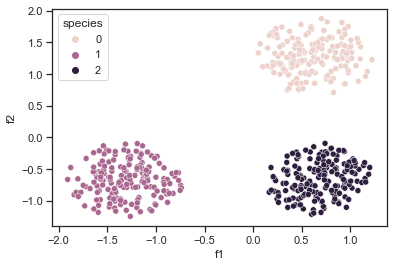

In [6]:
# Make copy of the bound dataframe, as km_species
km_species = bd_species.copy()

# Detect and remove anomalies
anoms, km_species = detect_anomaly(km_species, km_assigner)
km_species = remove_anomalies(km_species, anoms)

# sanity
assert(len(anoms) == bd_species.shape[0] - km_species.shape[0])

# Show results
display(km_species)
show_scatter(km_species)

# 5. Use DBSCAN clustering to find anomalies.

In [7]:
# DBSCAN assigner function
def dbs_assigner(df):
    # Declare, fit, and predict
    dbs = DBSCAN(eps=0.25)
    assignments = dbs.fit_predict(df)
    
    return assignments, dbs.core_sample_indices_

Anomalies 93: 

(-1.48000289758, -1.09948040102)
(-1.58852748366, -0.819181976895)
(-1.8423736067400003, -0.9044378390629999)
(-1.60594123991, -0.76522411796)
(-1.58434365981, -0.845357036129)
(-1.8030774446900002, -0.65461097373)
(-1.7328692309, -1.08216857053)
(-1.7212991458000002, -0.7778487948780001)
(-1.6374839374099999, -0.707992965283)
(-1.82087781658, -0.868101472932)
(-1.57271416628, -0.9839497030140001)
(-1.47375056852, -0.955937874772)
(-1.26363865114, -1.2482421522299998)
(-1.42356222195, -1.11563240162)
(-1.7484060634599998, -0.757167172502)
(-1.5940591783700002, -1.18378628891)
(-1.6384800666, -1.12997990407)
(-1.61004687385, -0.988293010227)
(-1.67698616873, -0.808446550696)
(-1.4745828388100002, -1.0478034298799999)
(-1.4130839890399998, -1.16512495168)
(-1.58948534345, -1.07365303551)
(-1.7722071158300001, -0.866301255997)
(-1.79850796029, -0.934840788244)
(-1.9081642579400002, -0.664624198594)
(-1.87656067, -0.47611637158299996)
(-1.60183922321, -0.868539405266)
(0.43

,f1,f2,species
1,-1.428081,-0.837064,0
6,-1.301548,-0.762062,0
10,-1.215782,-0.601021,0
11,-1.250218,-1.057617,0
12,-1.051604,-0.780084,0
...,...,...,...
728,0.962171,1.330002,2
734,0.800860,0.881746,2
736,0.403732,1.165925,2
737,0.633083,0.852550,2


<AxesSubplot:xlabel='f1', ylabel='f2'>

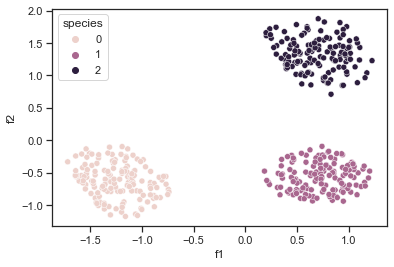

In [8]:
# Make copy of the KMeans dataframe as dbs_species
dbs_species = km_species.copy()

# Detect and remove anomalies
anoms, dbs_species = detect_anomaly(dbs_species, dbs_assigner)
dbs_species = remove_anomalies(dbs_species, anoms)

# sanity
assert(len(anoms) == km_species.shape[0] - dbs_species.shape[0])

# Show results
display(dbs_species)
show_scatter(dbs_species)

# 6. Using the cleaned dataset, develop a decision tree classifier and show the model decision tree.

From the output below we see that the first split in the tree captures species_a ('f1' <= 0.277, the next split then figures out which is species_b ('f2' <= 0.307), and species_c ('f2' > 0.307).

Scores: [1. 1. 1. 1. 1.]


[Text(133.92000000000002, 181.2, 'f1 <= -0.277\nsamples = 434\nvalue = [150, 141, 143]'),
 Text(66.96000000000001, 108.72, 'samples = 150\nvalue = [150, 0, 0]'),
 Text(200.88000000000002, 108.72, 'f2 <= 0.307\nsamples = 284\nvalue = [0, 141, 143]'),
 Text(133.92000000000002, 36.23999999999998, 'samples = 141\nvalue = [0, 141, 0]'),
 Text(267.84000000000003, 36.23999999999998, 'samples = 143\nvalue = [0, 0, 143]')]

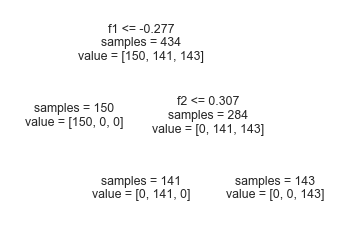

In [9]:
# Declare tree
tree = DecisionTreeClassifier()

# Declare KFold validator
kfold = KFold(n_splits=5)

# Split dbs_species into X and Y
X = dbs_species.loc[:, dbs_species.columns != 'species'].values
Y = dbs_species.loc[:, dbs_species.columns == 'species'].values.ravel()

# Cross validate with KFold (Sanity Check)
scores = cross_val_score(tree, X, Y, cv=kfold, scoring='accuracy')
print(f'Scores: {scores}')

# Show Structure
tree.fit(X, Y)
plot_tree(tree, feature_names=['f1', 'f2'], impurity=False)

# 7. Was it worth it?

I think the K-means and DBScan were probably worth it, but not necessarily the manual bounding, so let's run three experiments: 
* Just K-means clustering and removal
* Just DBScan clustering and removal
* Both K-means and DBScan clustring and removal

In [10]:
# Define the experimenter
def run_exp(assigners: list=[km_assigner, dbs_assigner]):
    # Make copy of the species dataframe, as exp_species
    exp_species = species_org.copy()

    anoms =[]
    for assigner in assigners:
        size_before = exp_species.shape[0]
        
        # Detect anomalies (naming species by clustering method)
        anoms, exp_species = detect_anomaly(exp_species, assigner)
        # Remove anomalies
        exp_species = remove_anomalies(exp_species, anoms)

        # sanity
        assert(len(anoms) == size_before - exp_species.shape[0])

        # Show results
        display(exp_species)
        show_scatter(exp_species)
        plt.show()
        plt.clf()
        
    # Declare tree
    tree = DecisionTreeClassifier()

    # Declare KFold validator
    kfold = KFold(n_splits=5)

    # Split dbs_species into X and Y
    X = exp_species.loc[:, exp_species.columns != 'species'].values
    Y = exp_species.loc[:, exp_species.columns == 'species'].values.ravel()

    # Cross validate with KFold (Sanity Check)
    scores = cross_val_score(tree, X, Y, cv=kfold, scoring='accuracy')
    print(f'Scores: {scores}')

    # Show Structure
    tree.fit(X, Y)
    plot_tree(tree, feature_names=['f1', 'f2'], impurity=False)

### Just K-means

Running just K-means clustering/removal yields a very similar , which indicates to me that both the bounding and DBScan we extraneous in this instance.

Anomalies 115: 

(0.45626316907799996, 2.05788223562)
(1.36805202458, 1.65962813336)
(-0.13447918058299999, 2.11039748445)
(0.46750572633500004, 0.450459334368)
(1.4820171759600003, 1.8271355569099998)
(1.22425496262, 0.501610912038)
(1.5362408842299997, 0.894604885123)
(1.68745105198, 1.2783075569600002)
(1.23408760826, 1.9761904039900002)
(1.5230735223899998, 0.741157517894)
(1.02546663264, 2.17903746819)
(-0.0094375858741, 2.06614833436)
(0.334806319729, 0.635350614538)
(0.7788503407619999, 2.09349071844)
(-0.128975958296, 1.09716295281)
(1.3160804209399999, 1.5734222566999998)
(-0.335795516652, 1.56140541417)
(1.2390151841200001, 1.8788219962200001)
(1.31845143924, 1.6940063228400002)
(0.196057452318, 2.06336452546)
(-0.376722258575, 1.5430006451700002)
(1.22185277774, 2.04479129366)
(0.316274690117, 2.05030729845)
(0.454419137278, 2.2457941917)
(1.4021067635, 1.45886382804)
(-0.23389735529199998, 1.40492904943)
(-0.221156389297, 0.90920018435)
(1.38939876357, 1.8831629694099998)
(

,f1,f2,species
0,0.494261,1.451067,0
1,-1.428081,-0.837064,1
2,0.338559,1.038759,0
4,1.122425,1.774937,0
6,-1.301548,-0.762062,1
...,...,...,...
744,-1.601839,-0.868539,1
745,0.505927,1.213927,0
746,-1.640461,-0.469973,1
748,-1.169394,0.039597,1


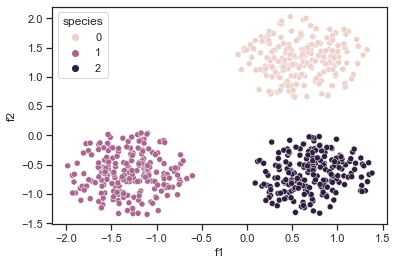

Scores: [1. 1. 1. 1. 1.]


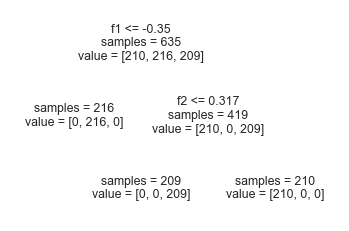

In [11]:
run_exp([km_assigner])

### Just DBScan

Here we see that some of the outliers removed by bounding get assigned to a unique species, which resulted in a sphagetti tree.

So in this case bounding is very useful.

Anomalies 130: 

(1.12242460445, 1.7749365443599998)
(0.884913340754, 1.6659170120700002)
(0.45626316907799996, 2.05788223562)
(1.36805202458, 1.65962813336)
(0.36316811521700004, 1.90748256868)
(1.4820171759600003, 1.8271355569099998)
(0.763176137366, 1.8231891339900002)
(0.38148148885600003, 1.90489980312)
(1.23408760826, 1.9761904039900002)
(1.02546663264, 2.17903746819)
(-0.0094375858741, 2.06614833436)
(0.7788503407619999, 2.09349071844)
(1.3160804209399999, 1.5734222566999998)
(1.2390151841200001, 1.8788219962200001)
(1.31845143924, 1.6940063228400002)
(0.196057452318, 2.06336452546)
(1.22185277774, 2.04479129366)
(0.914105951171, 1.8136403861099997)
(0.9789003013590001, 1.75109237406)
(1.0923761976200002, 1.7271683214099998)
(0.316274690117, 2.05030729845)
(1.23151797851, 1.52230461678)
(0.454419137278, 2.2457941917)
(1.4021067635, 1.45886382804)
(0.7037436757950001, 1.8729520970099998)
(1.21349899534, 1.6388133243)
(1.38939876357, 1.8831629694099998)
(1.07231521798, 1.812152310

,f1,f2,species
0,0.494261,1.451067,0
1,-1.428081,-0.837064,1
2,0.338559,1.038759,0
5,-1.261570,0.271881,1
6,-1.301548,-0.762062,1
...,...,...,...
743,0.493448,-0.820792,2
744,-1.601839,-0.868539,1
745,0.505927,1.213927,0
746,-1.640461,-0.469973,1


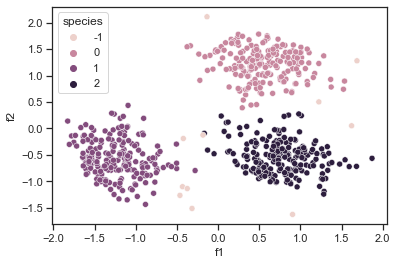

Scores: [0.96774194 0.98387097 0.99193548 0.98387097 0.96774194]


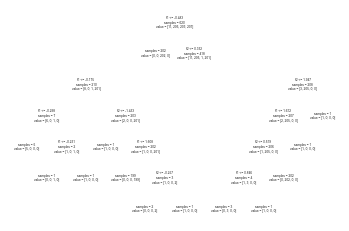

In [12]:
run_exp([dbs_assigner])

### Both K-Means and DBS

Here we see that K-Means controls for the extra species that would have been assigned by DBScan yielding the tree obtained from just K-Means.

Anomalies 115: 

(0.45626316907799996, 2.05788223562)
(1.36805202458, 1.65962813336)
(-0.13447918058299999, 2.11039748445)
(0.46750572633500004, 0.450459334368)
(1.4820171759600003, 1.8271355569099998)
(1.22425496262, 0.501610912038)
(1.5362408842299997, 0.894604885123)
(1.68745105198, 1.2783075569600002)
(1.23408760826, 1.9761904039900002)
(1.5230735223899998, 0.741157517894)
(1.02546663264, 2.17903746819)
(-0.0094375858741, 2.06614833436)
(0.334806319729, 0.635350614538)
(0.7788503407619999, 2.09349071844)
(-0.128975958296, 1.09716295281)
(1.3160804209399999, 1.5734222566999998)
(-0.335795516652, 1.56140541417)
(1.2390151841200001, 1.8788219962200001)
(1.31845143924, 1.6940063228400002)
(0.196057452318, 2.06336452546)
(-0.376722258575, 1.5430006451700002)
(1.22185277774, 2.04479129366)
(0.316274690117, 2.05030729845)
(0.454419137278, 2.2457941917)
(1.4021067635, 1.45886382804)
(-0.23389735529199998, 1.40492904943)
(-0.221156389297, 0.90920018435)
(1.38939876357, 1.8831629694099998)
(

,f1,f2,species
0,0.494261,1.451067,0
1,-1.428081,-0.837064,1
2,0.338559,1.038759,0
4,1.122425,1.774937,0
6,-1.301548,-0.762062,1
...,...,...,...
744,-1.601839,-0.868539,1
745,0.505927,1.213927,0
746,-1.640461,-0.469973,1
748,-1.169394,0.039597,1


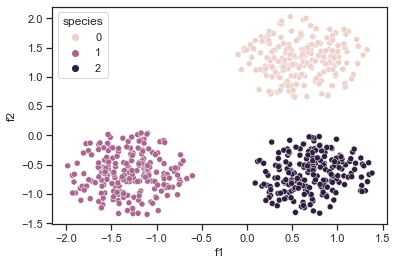

Anomalies 102: 

(1.12242460445, 1.7749365443599998)
(0.884913340754, 1.6659170120700002)
(0.492824086051, 1.7827442192299998)
(0.36316811521700004, 1.90748256868)
(0.6056172364010001, 1.70403704905)
(0.763176137366, 1.8231891339900002)
(0.38148148885600003, 1.90489980312)
(0.5958236251560001, 1.74945400458)
(1.28347766291, 1.3709761910299998)
(1.10613565156, 1.4303998031999998)
(0.914105951171, 1.8136403861099997)
(0.9789003013590001, 1.75109237406)
(1.0923761976200002, 1.7271683214099998)
(0.245343426191, 1.77834730722)
(1.23151797851, 1.52230461678)
(0.7037436757950001, 1.8729520970099998)
(1.21349899534, 1.6388133243)
(0.596690144163, 1.72643881439)
(0.7285009017149999, 1.68709745134)
(1.07231521798, 1.81215231098)
(0.384580005797, 1.9528285301700001)
(0.480499087021, 2.02664864155)
(1.0832268626600001, 1.50007405277)
(1.00649041199, 1.53362494993)
(1.07207441854, 1.56204556067)
(0.6219208989630001, 1.9737597649599998)
(0.94555298466, 1.70764263243)
(0.6522709149270001, 2.001981395

,f1,f2,species
0,0.494261,1.451067,0
1,-1.428081,-0.837064,1
2,0.338559,1.038759,0
6,-1.301548,-0.762062,1
7,0.585699,-0.339105,2
...,...,...,...
740,0.674247,-0.335924,2
743,0.493448,-0.820792,2
745,0.505927,1.213927,0
746,-1.640461,-0.469973,1


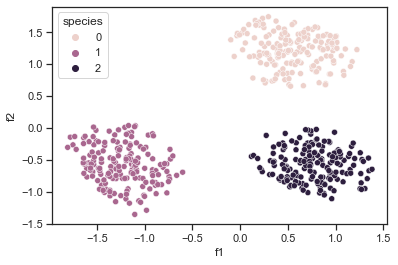

Scores: [1. 1. 1. 1. 1.]


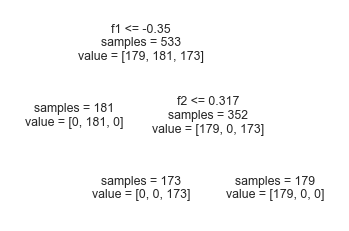

In [13]:
run_exp([km_assigner, dbs_assigner])

### 7. Conclusion

Based on the above three experiments, I think it is safe to say that in this case we could have just used K-means clustering label the species and build the tree.

We could *not* build the tree with just DBScan as it fails to properly classify and remove some outlying datapoints. There might have been away for us to remove 'species -1' from those experiments, which would likely have produced a more satisfatory result but that requires more input from us than K-means clustering.

### One Last Experiment

What happens when we just build the tree using the clustering generated by K-means without anomaly removal?

,f1,f2,species
0,0.494261,1.451067,0
1,-1.428081,-0.837064,1
2,0.338559,1.038759,0
3,0.119001,-1.053976,2
4,1.122425,1.774937,0
...,...,...,...
745,0.505927,1.213927,0
746,-1.640461,-0.469973,1
747,-0.057139,-0.909261,2
748,-1.169394,0.039597,1


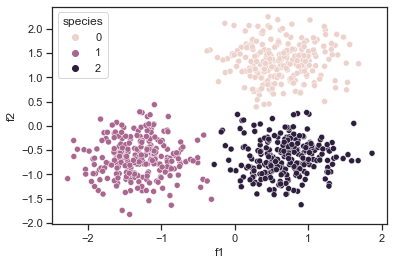

Scores: [1.         1.         1.         0.98666667 0.99333333]


[Text(167.4, 181.2, 'f1 <= -0.298\nsamples = 750\nvalue = [248, 252, 250]'),
 Text(83.7, 108.72, 'f2 <= 0.989\nsamples = 254\nvalue = [2, 252, 0]'),
 Text(41.85, 36.23999999999998, 'samples = 252\nvalue = [0, 252, 0]'),
 Text(125.55000000000001, 36.23999999999998, 'samples = 2\nvalue = [2, 0, 0]'),
 Text(251.10000000000002, 108.72, 'f2 <= 0.332\nsamples = 496\nvalue = [246, 0, 250]'),
 Text(209.25, 36.23999999999998, 'samples = 250\nvalue = [0, 0, 250]'),
 Text(292.95, 36.23999999999998, 'samples = 246\nvalue = [246, 0, 0]')]

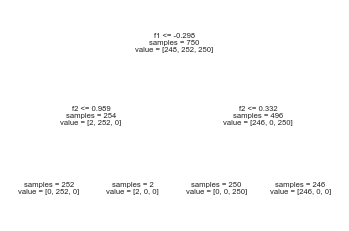

In [14]:
# One last experiment (don't remove datapoints from K-means)

# Make copy of the species dataframe, as exp_species
exp_species = species_org.copy()

anoms =[]

# Get K-means labels
_, exp_species = detect_anomaly(exp_species, km_assigner, verbose=False)

# Show results
display(exp_species)
show_scatter(exp_species)
plt.show()
plt.clf()

# Declare tree
tree = DecisionTreeClassifier()

# Declare KFold validator
kfold = KFold(n_splits=5)

# Split dbs_species into X and Y
X = exp_species.loc[:, exp_species.columns != 'species'].values
Y = exp_species.loc[:, exp_species.columns == 'species'].values.ravel()

# Cross validate with KFold (Sanity Check)
scores = cross_val_score(tree, X, Y, cv=kfold, scoring='accuracy')
print(f'Scores: {scores}')

# Show Structure
tree.fit(X, Y)
plot_tree(tree, feature_names=['f1', 'f2'], impurity=False)

Still worked pretty well, but it appears that at the very least we should remove the anomalies from the K-Means produced dataset if we want a sane tree. 